# Social graphs and interactions

# Assignment 1

#### Group 30:

Aleksandar Lukic, s194066

Clara Mejlhede Lorenzen, s180350

Julia Katarzyna Zalewska, s244491

## Part 1: Exploring the friendship paradox.

In [32]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

# Create an initial graph with a single link (connecting 0 and 1)
G = nx.Graph()
G.add_edge(0, 1)

# Add nodes, connecting each to the existing nodes with probability proportional to their degree
def add_node_with_preferential_attachment(G, new_node):
    
    degrees = [node for node, degree in G.degree() for _ in range(degree)]
    
    # attach the new node to existing node
    chosen_node = random.choice(degrees)
    G.add_edge(new_node, chosen_node)

# Keep going until you have a 100 node network.
for i in range(2, 100):
    add_node_with_preferential_attachment(G, i)

# Add more nodes until you have a 5000 node network.
for i in range(100, 5000):
    add_node_with_preferential_attachment(G, i)

# What's the maximum and minimum degree?
degrees = [degree for node, degree in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)

# Bin the degree distribution using numpy.histogram.
hist, bin_edges = np.histogram(degrees, bins=range(min_degree, max_degree + 2), density=True)

#### The friendship paradox in BA networks

<font color='gray'> Pick a node i at random (e.g. use random.choice). Find its degree.</font>

In [36]:
# Find random node i 
random_node = random.choice(list(G.nodes))

# Find its degree
node_degree = G.degree[random_node]
print(f"Degree of node_i {random_node}: {node_degree}")

Degree of node_i 3868: 1


<font color='gray'> Find i's neighbors. And calculate their average degree.</font>

In [37]:
# Find neighbors and their degrees
neighbors = list(G.neighbors(random_node))
neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

# Calculate neighbors_degree 
if len(neighbor_degrees) > 0:
    neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
else:
    neighbor_degree = 0

print(f"Degree of neighbor_i {random_node}: {neighbor_degree}")

Degree of neighbor_i 3868: 4.0


<font color='gray'> Compare the two numbers to check if it's true that i's friends (on average) have more friends than i.</font>

In [39]:
if node_degree < neighbor_degree:
    print("It is true, i's friends has more friends than i") 
else:
    print("It is not true, i has more friends than i's friends")

It is true, i's friends has more friends than i


<font color='gray'> Do this 1000 times. How many out of those 1000 times is the friendship paradox true in F-BA?</font>

In [40]:
t = 0
f = 0

for i in range(1000):
    # Find random node i 
    random_node = random.choice(list(G.nodes))

    # Find its degree
    node_degree = G.degree[random_node]    
    
    # Find neighbors and their degrees
    neighbors = list(G.neighbors(random_node))
    neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

    # Calculate neighbors_degree 
    if len(neighbor_degrees) > 0:
        neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
    else:
        neighbor_degree = 0
    
    if node_degree < neighbor_degree:
        t += 1 
    else:
        f += 1

print(f"The friendship paradox is true {t} times and false {f} times out of 1000 times in total")

The friendship paradox is true 877 times and false 123 times out of 1000 times in total


#### The friendship paradox more generally

<font color='gray'> What if the power law is flatter, e.g. p(k)∼k^(−γ) with γ=2? Will the fraction of times the paradox is true be higher or lower?</font>

Since the power-law distribution is skewed, when γ=2, the fraction of times the paradox is true will be higher. 

* For a steep power-law, the nodes will have low degrees, and only a few hubs will exist.

* For a flatter power-law, there are more high-degree nodes, meaning that many more nodes are relatively well-connected.

<font color='gray'> First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law is flatter?</font>

With a flatter power law, the gap between a node and the hubs is smaller because hubs will be more common. 

A randomly chosen node is likely to have neighbors with similar degrees. Therefore, the Friendship Paradox (the idea that your friends have more friends than you) will hold more frequently since there are many well-connected nodes in the neighborhood of any given node.

<font color='gray'> Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree 
distributions using the configuation model. The networkx funtion is here nx.configuration_model. I suggest you make the network pretty big ... let's say 5000 nodes or more.</font>

We will below make the simulation by defining the degrees and ensuring that the sum of the degrees are even. Then creating the configuration model graph and removing the parallel edges and self-loops

This will give an idea of how the "slope" can look like. Similar to a power-law graph.

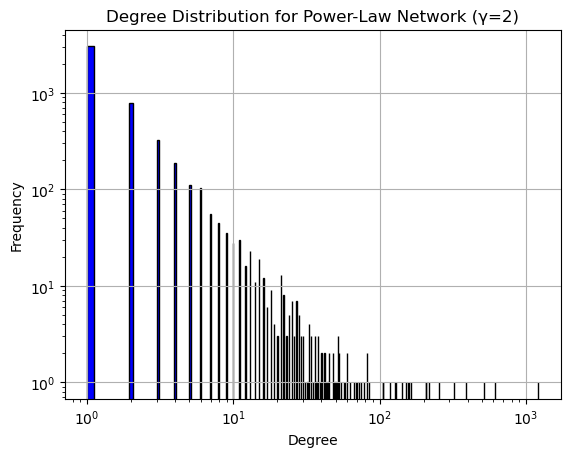

In [44]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

n = 5000
gamma = 2

# Degrees following p(k) ~ k^(-gamma)
degree_sequence = np.random.zipf(gamma, n)

# Ensure the sum of degrees is even
if sum(degree_sequence) %  2 != 0:
    degree_sequence[0] += 1

# Create the configuration model graph
G = nx.configuration_model(degree_sequence)

# Remove parallel edges and self-loops
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# Plot the degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins='auto', color='blue', edgecolor='black')

plt.title('Degree Distribution for Power-Law Network (γ=2)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

<font color='gray'> Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a new slope?</font>

Below we are calculating the fraction of times the Friendship Paradox is true  

In [45]:
import random
import numpy as np

# Initialize counts for the friendship paradox
paradox_true = 0
paradox_false = 0

# Testing the test n times
n = 1000

for _ in range(n):
    
    random_node = random.choice(list(G.nodes))
    node_degree = G.degree[random_node]
    neighbors = list(G.neighbors(random_node))
    
    # Find the degree of neighbors
    if len(neighbors) > 0:
        neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)
    
    else:
        avg_neighbor_degree = 0
    
    # Checking if friendship paradox holds
    if node_degree < avg_neighbor_degree:
        paradox_true += 1
    
    else:
        paradox_false += 1

fraction_true = paradox_true / (paradox_true + paradox_false)
print(f"Friendship Paradox is true {fraction_true*100}% of the time")

Friendship Paradox is true 90.60000000000001% of the time


#### The friendship paradox and the configuration model

<font color='gray'> Now generate a network for the configuration model that has the same slope and number of nodes as F-BA* in A 
above; let's call this new network F-CM* (for friendship configuration model).</font>

We will here generate a new network for the configuration model with the same slope and number of nodes as for the F-BA. This is done by generating the degree sequence from F-BA and then creating a configuration model based on that degree sequence. We then convert it to a graph with no multi-edges or self-loops and plot the F-CM network.

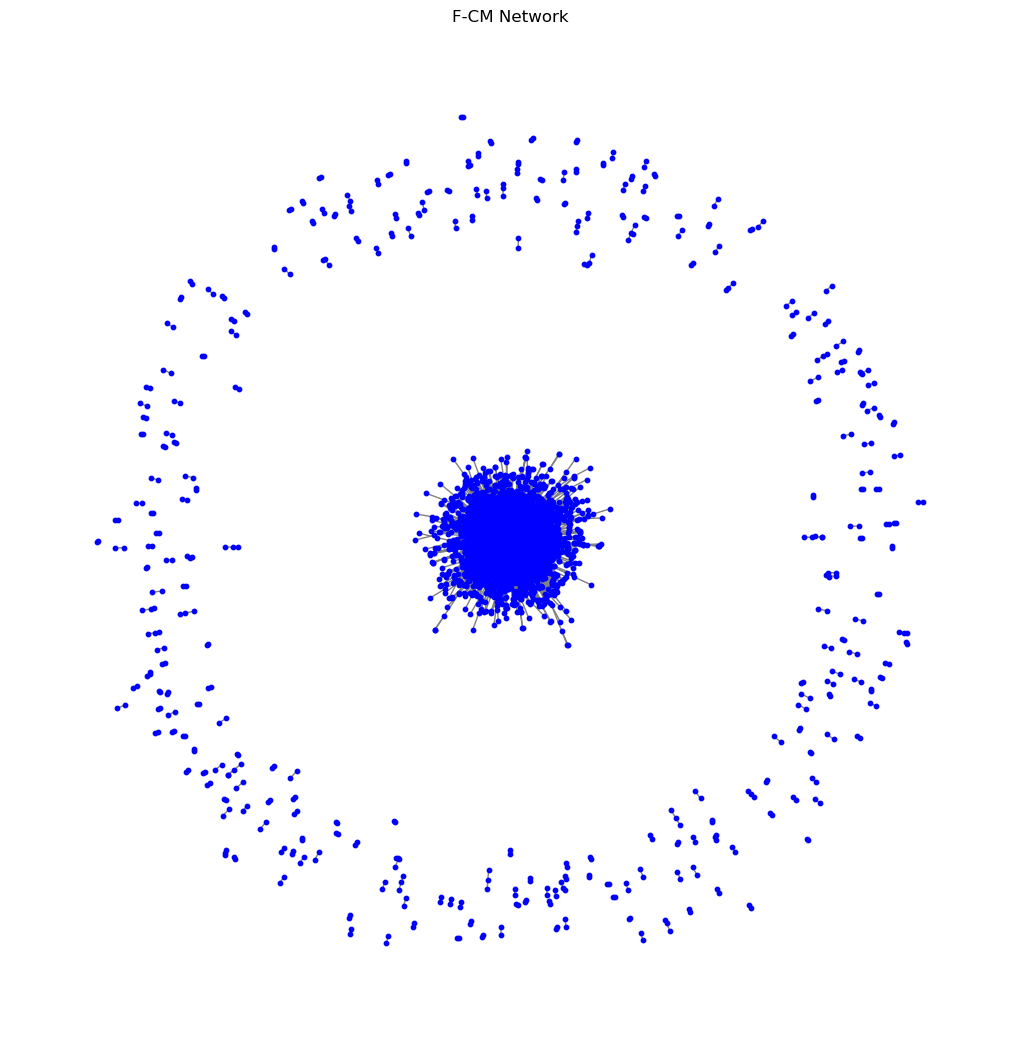

In [50]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Using the degree sequence from the F-BA network
degree_sequence = [G.degree(n) for n in G.nodes()]

# Generate the configuration model, F-CM
F_CM_star = nx.configuration_model(degree_sequence)

# Convert to graph
F_CM_star = nx.Graph(F_CM_star)
F_CM_star.remove_edges_from(nx.selfloop_edges(F_CM_star))

# Plot the F-CM Network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(F_CM_star, seed=42)
nx.draw(F_CM_star, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("F-CM Network")
plt.show()

<font color='gray'> What fraction of the time is the friendship paradox is true for the F-CM network?</font>

We will now calculate the fraction of times, for the F-CM network, where the Friendship Paradox is true.

In [51]:
# Initialize counts for the friendship paradox
paradox_true_FCM = 0
paradox_false_FCM = 0

# Testing the test n times
n = 1000

for _ in range(n):
    random_node = random.choice(list(F_CM.nodes))

    node_degree = F_CM.degree[random_node]

    neighbors = list(F_CM.neighbors(random_node))

    # Find the degree of neighbors
    if len(neighbors) > 0:
        neighbor_degrees = [F_CM.degree[neighbor] for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)
    else:
        avg_neighbor_degree = 0
    
    # Checking if friendship paradox holds
    if node_degree < avg_neighbor_degree:
        paradox_true_FCM += 1
    else:
        paradox_false_FCM += 1

fraction_true_FCM = paradox_true_FCM / (paradox_true_FCM + paradox_false_FCM)
print(f"The Friendship Paradox is true {fraction_true_FCM*100}% of the time in F-CM")

The Friendship Paradox is true 88.1% of the time in F-CM


<font color='gray'> Assuming that F-BA and F-CM have the same degree sequence can now think about if F-BA and F-CM are different with respect to the friendship paradox. Specifically, please explain your thoughts on the following topics </font>

Even with the same degree sequence. There will still be a differences between F-BA and F-CM. 

* The degree correlation will still be different. The F-CM's connections will be more random  than the F-BA's connections. This could result in a lower Friendship Paradox clustering for the F-CM since it will reduce the likelihood of the paradox occuring compared to the F-BA.  

* The clustering will tell us how interconnected a node's neighbors are and in F-CM the cluster coefficient will be lower that F-BA.

#### Growth without preferential attachment

<font color='gray'> Finally, we'll build a network of same size and degree as in the exercise above, using the growth mechanism without the preferential attachment. Follow the steps below for success </font>

1. <font color='gray'> Grow a new network (the Sune-network) with the same parameters as the F-BA network in the exercise above, i.e. 5000 nodes, each new node connects to the existing network, but with one key difference: have the incoming nodes connect to the existing nodes with equal probability. This is the Sune-network.</font>

Below we have created the Sune-network. First we initialize the network with two connecting nodes and are then able to grow the network to our parameters as the F-BA network, i.e. 5000 nodes. 

The Sune-network will grow similarly to the F-BA network but with each incoming nodes connects to the existing nodes with equal probability of receiving a new connection.

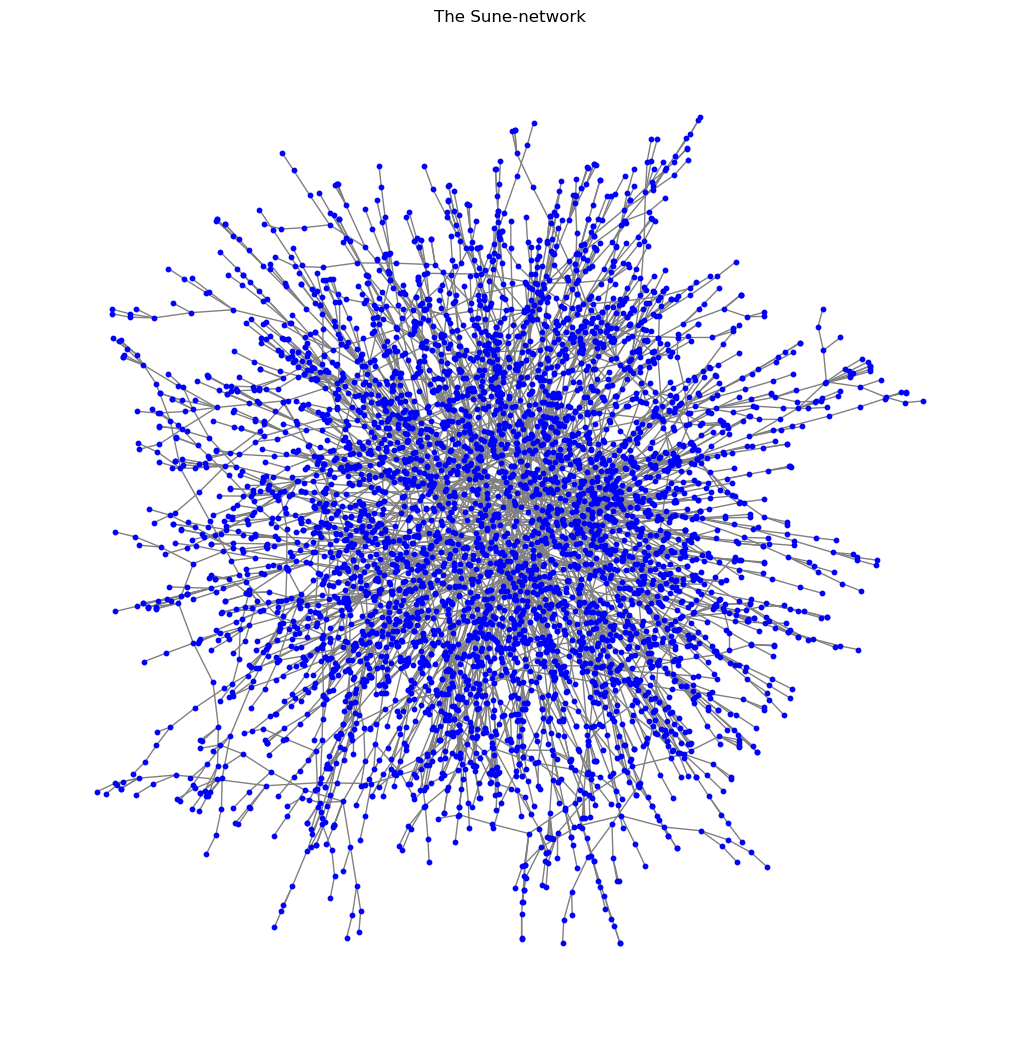

In [52]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Initialize the network with 2 connected nodes
Sune_network = nx.Graph()
Sune_network.add_edge(0, 1)

# Number of nodes in the final network
num_nodes = 5000

# Grow the network
for new_node in range(2, num_nodes):
    target_node = random.choice(list(Sune_network.nodes))
    Sune_network.add_edge(new_node, target_node)

# Plot the Sune-network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(Sune_network, seed=42)
nx.draw(Sune_network, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("The Sune-network")
plt.show()

2. <font color='gray'> Generate an ER network of same number of nodes and links as the Sune-network.</font>

To generate an ER network of same number of nodes and links as above, we will first count the number of edges in the Sune-network and afterwerds generate an ER network with the same number of nodes and edges.

The ER network is a random network where edges are placed between nodes with a fixed probability. 

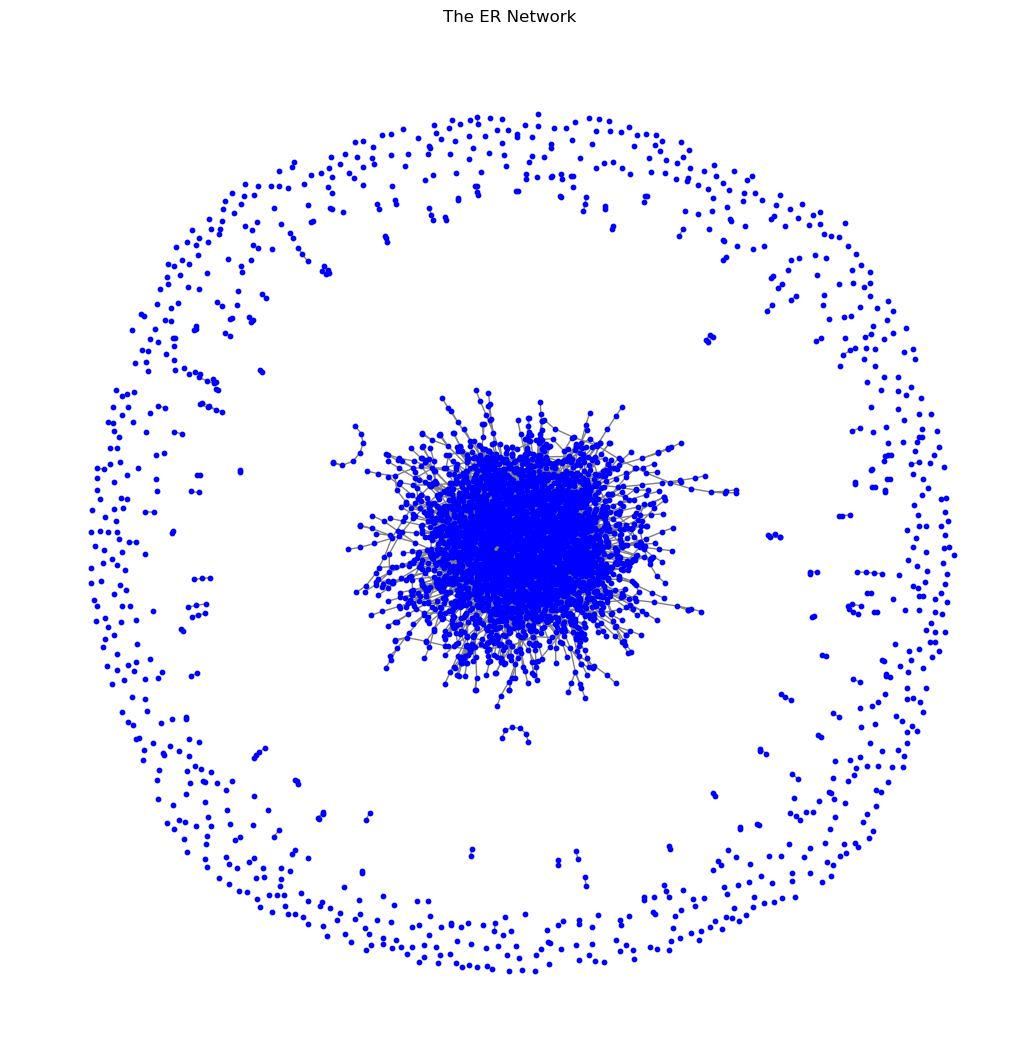

In [53]:
# Counting the number of edges in the Sune-network
num_edges = Sune_network.number_of_edges()

# Generate ER network with the same number of nodes and edges
ER_network = nx.gnm_random_graph(num_nodes, num_edges)

# Plot the ER Network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(ER_network, seed=42)
nx.draw(ER_network, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("The ER Network")
plt.show()

The Sune-network is grown similarly to the BA model but without preferential attachment, making connections purely 
random among existing nodes.

The ER network is generated using the same number of nodes (5000) and edges as the Sune-network to ensure a 
fair comparison.

This is visualized in the histogram below where we compare the two degree distribution. We can here see that the Sune-Network have a more skewed distribution, with a larger number of low degree nodes. The ER Network have a more narrow degree distribution, having most nodes having degrees closer to the average degree

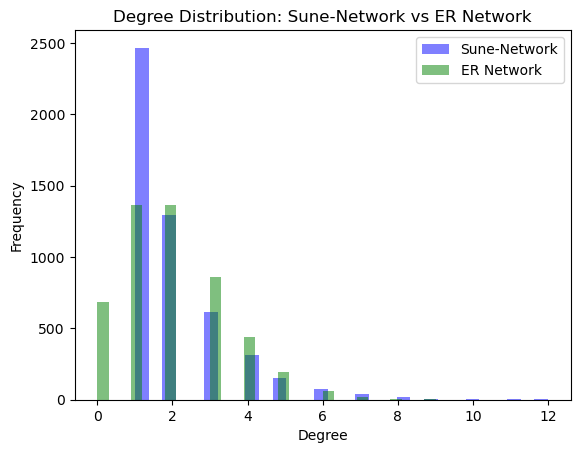

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Generate the Sune-Network
Sune_network = nx.Graph()
Sune_network.add_edge(0, 1)
num_nodes = 5000

for new_node in range(2, num_nodes):
    target_node = random.choice(list(Sune_network.nodes))
    Sune_network.add_edge(new_node, target_node)

# Get the number of edges in the Sune-network
num_edges = Sune_network.number_of_edges()

# Create ER network with same number of nodes and edges
ER_network = nx.gnm_random_graph(num_nodes, num_edges)

# Histogram of distribution of Sune-Network
sune_degrees = [Sune_network.degree(n) for n in Sune_network.nodes()]
plt.hist(sune_degrees, bins=30, alpha=0.5, label="Sune-Network", color="blue")

# Histogram of distribution of ER Network
er_degrees = [ER_network.degree(n) for n in ER_network.nodes()]
plt.hist(er_degrees, bins=30, alpha=0.5, label="ER Network", color="green")

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution: Sune-Network vs ER Network")
plt.show()

The number of connected components are calculated below. Here we can see a very skewed difference between the two networks. 

In [59]:
# Compute and Compare Number of Connected Components
sune_components = nx.number_connected_components(Sune_network)
er_components = nx.number_connected_components(ER_network)

print(f"Sune-Network has {sune_components} connected components.")
print(f"ER Network has {er_components} connected components.")

Sune-Network has 1 connected components.
ER Network has 807 connected components.


## Part 2: Stats of the Country Music Network